# need data for each game and final score

In [1]:
import requests
import pprint
import os
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [153]:
seasons = list(range(2010,2011))
max_game_id = 1313 # 32 teams can play 82 games each ... 32*82/2 == 1312


for season in seasons:
    print(f'...scraping {season}-{str(season+1)[2:]}')
    # scrape games for this season
    games = []
    last_date = '' # in case some games do not record a startDate
    for game_id in range(1, max_game_id):
        try:
            r = requests.get(f'https://statsapi.web.nhl.com/api/v1/game/{season}02{str(game_id).zfill(4)}/linescore')
            d = r.json()

            szn = f'{season}-{str(season+1)[2:]}'
            try:
                date = d['periods'][0]['startTime']
                last_date = date
            except:
                date = last_date
            last_period = d['periods'][-1]
            last_period_type = last_period['periodType']
            home_team = d['teams']['home']['team']['name']
            away_team = d['teams']['away']['team']['name']
            home_goals = d['teams']['home']['goals']
            away_goals = d['teams']['away']['goals']
            games.append([szn, date, last_period_type, home_team, away_team, home_goals, away_goals])
        except:
            print('could not find gameId: ' + str(game_id))
            break
    df = pd.DataFrame(games)
    df.columns = ['season', 'date', 'period_type', 'home_team', 'away_team', 'home_goals', 'away_goals']
    
    # calculate which teams get points in game
    df['home_points'] = np.where(df['home_goals']>df['away_goals'], 2,
                                 np.where(df['period_type']=='OVERTIME', 1, 0))

    df['away_points'] = np.where(df['home_goals']<df['away_goals'], 2,
                                 np.where(df['period_type']=='OVERTIME', 1, 0))

    # convert datetime to date
    df['date'] = pd.to_datetime(df['date']).dt.date

    # alter dataframe to have 3 columns: date, team, and points 
    df_home = df[['season', 'date', 'home_team', 'home_points']]
    df_home.columns = ['season', 'date', 'team', 'points']
    df_away = df[['season', 'date', 'away_team', 'away_points']]
    df_away.columns = ['season', 'date', 'team', 'points']
    df = result = pd.concat([df_home, df_away]).sort_values('date')

    #########################################
    # scrape divisions for this season
    r = requests.get(f'https://statsapi.web.nhl.com/api/v1/teams?season={season}{season+1}')
    d = r.json()
    team_and_division = [[team['name'], team['division']['name'], team['conference']['name']] for team in d['teams']]
    df_divisions = pd.DataFrame(team_and_division)
    df_divisions.columns = ['team', 'division', 'conference']
    
    # merge division/conference for each team
    df.sort_values(by=['team', 'date'], inplace=True)
    df_divisions.sort_values(by=['team'], inplace=True)
    df = df.merge(df_divisions, how='left', on='team')
    
    #########################################
    df.to_csv(f'linescore/games{season}-{str(season+1)[2:]}.csv', index=False)
    print(f'scraped {len(df)} games')
    print()

...scraping 2010-11
could not find gameId: 1231
scraped 2460 games



# test on games from 2020-21 season

In [99]:
df = pd.read_csv('linescore/games2018-19.csv')
df.head()

,season,date,team,points,division,conference
0,2018-19,2018-10-04,Anaheim Ducks,2,Pacific,Western
1,2018-19,2018-10-07,Anaheim Ducks,2,Pacific,Western
2,2018-19,2018-10-09,Anaheim Ducks,2,Pacific,Western
3,2018-19,2018-10-11,Anaheim Ducks,1,Pacific,Western
4,2018-19,2018-10-14,Anaheim Ducks,0,Pacific,Western


### calculate cumulative point totals and total percentage of points for any day

In [100]:
# get a cumulative sum of points for each team
df['cum_points'] = df.groupby('team')['points'].cumsum()

# get points percentage for each team
df['possible_points'] = [2] * len(df)
df['total_possible_points'] = df.groupby('team')['possible_points'].cumsum()
df['points_pct'] = df['cum_points'] / df['total_possible_points']

In [101]:
# find cumulative points threshold for divisional playoff spot
def division_playoff_spot(row, df):
    date = row.date
    division = row.division
    cutoff = 2
    if row.season <= '2012-13':
        cutoff = 0
    try:
        return df[(df['date'] <= date) &
                   (df['division']==division)] \
                    .sort_values(by='date', ascending=False) \
                    .drop_duplicates(subset = ["team"]) \
                    .sort_values(by='cum_points', ascending=False) \
                    .reset_index()['cum_points'][cutoff]
    except:
        return 0  # need this in start of season when less than 3 teams have played a game

# find cumulative points threshold for conference playoff spot
def conference_playoff_spot(row, df):
    date = row.date
    conference = row.conference
    try:
        return df[(df['date'] <= date) &
                   (df['conference']==conference)] \
                    .sort_values(by='date', ascending=False) \
                    .drop_duplicates(subset = ["team"]) \
                    .sort_values(by='cum_points', ascending=False) \
                    .reset_index()['cum_points'][7]
    except:
        return 0  # need this in start of season when less than 3 teams have played a game



In [102]:
# 'learn' how many points a team is out of a divisional playoff spot on any day
df['division_threshold'] = [division_playoff_spot(row, df) for row in df.itertuples()]
df['points_above_division_spot'] = df['cum_points'] - df['division_threshold']

# 'learn' how many points a team is out of a conference playoff spot on any day
df['conference_threshold'] = [conference_playoff_spot(row, df) for row in df.itertuples()]
df['points_above_conference_spot'] = df['cum_points'] - df['conference_threshold']

In [107]:
df_team = df[df['team']=='Calgary Flames']
df_team

,season,date,team,points,division,conference,cum_points,possible_points,total_possible_points,points_pct,division_threshold,points_above_division_spot,conference_threshold,points_above_conference_spot
328,2018-19,2018-10-04,Calgary Flames,0,Pacific,Western,0,2,2,0.000000,0,0,0,0
329,2018-19,2018-10-07,Calgary Flames,2,Pacific,Western,2,2,4,0.500000,2,0,2,0
330,2018-19,2018-10-10,Calgary Flames,2,Pacific,Western,4,2,6,0.666667,4,0,4,0
331,2018-19,2018-10-12,Calgary Flames,0,Pacific,Western,4,2,8,0.500000,5,-1,4,0
332,2018-19,2018-10-14,Calgary Flames,2,Pacific,Western,6,2,10,0.600000,6,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,2018-19,2019-03-30,Calgary Flames,2,Pacific,Western,103,2,156,0.660256,90,13,85,18
406,2018-19,2019-04-01,Calgary Flames,2,Pacific,Western,105,2,158,0.664557,91,14,85,20
407,2018-19,2019-04-02,Calgary Flames,2,Pacific,Western,107,2,160,0.668750,93,14,86,21
408,2018-19,2019-04-04,Calgary Flames,0,Pacific,Western,107,2,162,0.660494,93,14,88,19


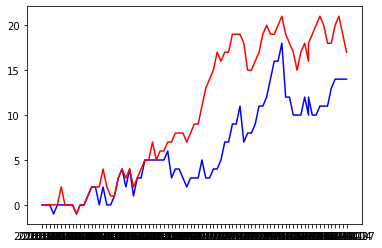

In [108]:
display(plt.plot(df_team['date'], df_team['points_above_division_spot'], linestyle = 'solid', color='blue'))
display(plt.plot(df_team['date'], df_team['points_above_conference_spot'], linestyle = 'solid', color='red'))


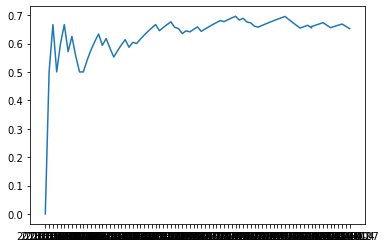

In [109]:
display(plt.plot(df_team['date'], df_team['points_pct'], linestyle = 'solid'))

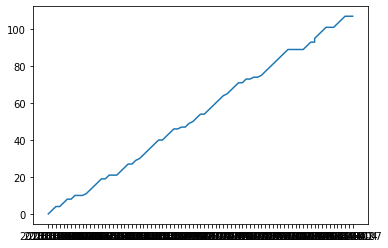

In [110]:
display(plt.plot(df_team['date'], df_team['cum_points'], linestyle = 'solid'))

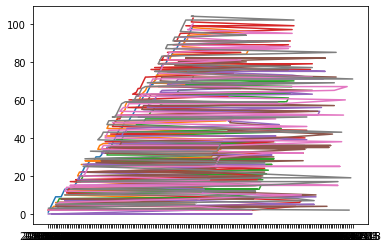

In [131]:
for team in df_div['team'].unique():
    df_tmp = df_div[df_div['team']==team].sort_values(by='date').copy().reset_index()
    plt.plot(df_tmp['date'], df_tmp['cum_points'], linestyle = 'solid')
plt.show()

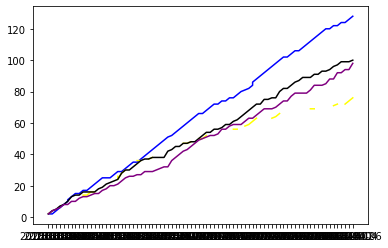

In [151]:
df_tmp = df[df['team']=='Tampa Bay Lightning'].sort_values(by='date')
df_tmp = df_tmp.merge(df[df['team']=='Buffalo Sabres'].sort_values(by='date'), how='left', on='date')
display(plt.plot(df_tmp['date'], df_tmp['cum_points_x'], linestyle = 'solid', color='blue'))
display(plt.plot(df_tmp['date'], df_tmp['cum_points_y'], linestyle = 'solid', color='yellow'))

display(plt.plot(df_tmp['date'], df_tmp['division_threshold_x'], linestyle = 'solid', color='black'))
display(plt.plot(df_tmp['date'], df_tmp['conference_threshold_x'], linestyle = 'solid', color='purple'))






In [148]:
df_tmp.merge(df[df['team']=='Boston Bruins'].sort_values(by='date'), how='left', on='date')


,season_x,date,team_x,points_x,division_x,conference_x,cum_points_x,possible_points_x,total_possible_points_x,points_pct_x,...,division_y,conference_y,cum_points_y,possible_points_y,total_possible_points_y,points_pct_y,division_threshold_y,points_above_division_spot_y,conference_threshold_y,points_above_conference_spot_y
0,2018-19,2018-10-06,Tampa Bay Lightning,2,Atlantic,Eastern,2,2,2,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-19,2018-10-11,Tampa Bay Lightning,0,Atlantic,Eastern,2,2,4,0.500000,...,Atlantic,Eastern,6.0,2.0,8.0,0.750000,4.0,2.0,4.0,2.0
2,2018-19,2018-10-13,Tampa Bay Lightning,2,Atlantic,Eastern,4,2,6,0.666667,...,Atlantic,Eastern,8.0,2.0,10.0,0.800000,5.0,3.0,5.0,3.0
3,2018-19,2018-10-16,Tampa Bay Lightning,2,Atlantic,Eastern,6,2,8,0.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-19,2018-10-18,Tampa Bay Lightning,2,Atlantic,Eastern,8,2,10,0.800000,...,Atlantic,Eastern,8.0,2.0,12.0,0.666667,8.0,0.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2018-19,2019-03-30,Tampa Bay Lightning,0,Atlantic,Eastern,122,2,156,0.782051,...,Atlantic,Eastern,103.0,2.0,156.0,0.660256,97.0,6.0,92.0,11.0
80,2018-19,2019-04-01,Tampa Bay Lightning,2,Atlantic,Eastern,124,2,158,0.784810,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,2018-19,2019-04-02,Tampa Bay Lightning,0,Atlantic,Eastern,124,2,160,0.775000,...,Atlantic,Eastern,105.0,2.0,160.0,0.656250,99.0,6.0,94.0,11.0
82,2018-19,2019-04-04,Tampa Bay Lightning,2,Atlantic,Eastern,126,2,162,0.777778,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
